<a href="https://colab.research.google.com/github/redman157/phamson/blob/master/Kaggle_API_access_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"fbb42254260432f50c3f1ff2db02d046"}'}

In [21]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Nov 10 16:33 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [28]:
# List available datasets.
!kaggle datasets list

ref                                                 title                                               size  lastUpdated          downloadCount  
--------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
kaggle/kaggle-survey-2018                           2018 Kaggle ML & DS Survey Challenge                 4MB  2018-11-03 22:35:07           1750  
lava18/google-play-store-apps                       Google Play Store Apps                               2MB  2018-09-18 20:49:49          17296  
census/family-households-with-married-couples-data  Family Households with Married Couples Data          2KB  2018-11-07 09:42:49           1092  
kmader/skin-cancer-mnist-ham10000                   Skin Cancer MNIST: HAM10000                          3GB  2018-09-20 20:36:13           2071  
xvivancos/transactions-from-a-bakery                Transactions from a bakery                         113KB  2018-09-

In [30]:
!kaggle competitions download -c digit-recognizer

 86% 63.0M/73.2M [00:00<00:00, 122MB/s]
100% 73.2M/73.2M [00:00<00:00, 169MB/s]
 86% 42.0M/48.8M [00:00<00:00, 50.4MB/s]
100% 48.8M/48.8M [00:00<00:00, 120MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 28.7MB/s]


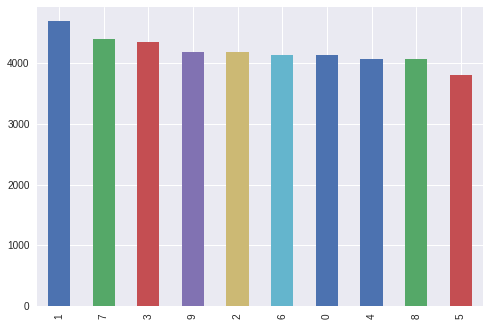

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from tensorflow import keras


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
y_train = train_data.label
X_train  = train_data.drop('label',axis = 1)
def load_data(path,data_path):
  if os.path.exists(path)  is False:
    data = load_data()
    with open(path, 'wb') as f:
      pickle.dump(data_path,f)
    f.close()
  else:
    with open(path,'rb') as f:
      data = pickle.load(f)
    f.close()
  return data
def load_dataset():
  pass
y_train.value_counts().plot.bar()